# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [64]:
# Set the theme here
THEME = 'war_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [65]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [66]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [67]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20 # This was lowered from 50 to 10 for gender_HU
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [68]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,u2017-11-27-183,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-27,Unicameralism,7,NaN,89,1,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Németh, Zsolt",M,1963.0,Tisztelt Ház! Tisztelt Miniszter Úr! Szeptembe...,Október hónapban a Magyar Országgyűlésben kia...,0.548828,1552
1,u2017-12-12-69,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-12-12,Unicameralism,7,NaN,90,2,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Hörcsik, Richárd",M,1955.0,Köszönöm a szót. Tisztelt Elnök Úr! Tisztelt Á...,Tisztelt Elnök Úr! Tisztelt Államtitkár Úr! T...,0.466309,10455
2,u2017-03-06-175,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-03-06,Unicameralism,7,NaN,74,1,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Gelencsér, Attila",M,1968.0,"Köszönöm a szót, elnök úr. Tisztelt Államtitká...",Tisztelt Államtitkár Úr! Hosszú ideje már ann...,-0.120667,2007
3,u2017-03-06-301,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-03-06,Unicameralism,7,NaN,74,1,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Harangozó, Gábor István",M,1975.0,"Köszönöm, elnök úr. A Magyar Zoltán képviselőt...",A Magyar Zoltán képviselőtársam által elmondo...,-0.585449,4576
4,u2017-02-20-5,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-02-20,Unicameralism,7,NaN,73,1,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Tóth, Bertalan",M,1975.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Miniszterelnök Úr!...,-0.931641,6881


In [69]:
df['Speaker_party'].describe()

count                794
unique                17
top       Fidesz-frakció
freq                 229
Name: Speaker_party, dtype: object

In [70]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [71]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)


In [72]:
pd.Series(new_topics).value_counts()

 0     126
 1     120
 2      86
 3      73
 4      68
 5      64
 6      63
 9      51
 8      50
 7      39
 10     28
 11     27
 12     23
-1       2
dtype: int64

In [73]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [74]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [75]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 14
Number of topics before: 14


In [76]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     200
 0      89
 7      69
 4      66
 9      62
 5      55
 3      53
 2      48
 11     38
 10     35
 12     31
 1      26
 8      25
 6      23
dtype: int64

In [77]:
topic_model.visualize_topics()

Topics over time

In [78]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [79]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [80]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [81]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

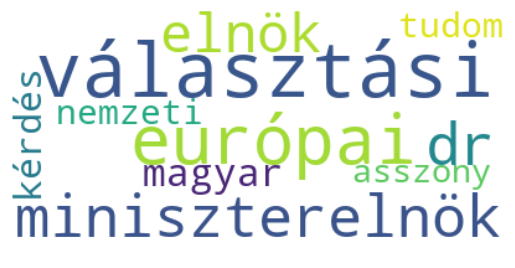

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [83]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [84]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['választási',
 'európai',
 'miniszterelnök',
 'dr',
 'elnök',
 'magyar',
 'kérdés',
 'nemzeti',
 'tudom',
 'asszony']

In [85]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-frakció' or 'JOBBIK-frakció'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-frakció|JOBBIK-frakció'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,20,29,71
1,53,13,49
2,14,13,58
3,26,14,31
4,30,13,22
5,24,13,25
6,17,13,32
7,8,19,11
8,8,10,30


In [86]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,9.6,19.2,19.9
1,25.4,8.6,13.7
2,6.7,8.6,16.2
3,12.4,9.3,8.7
4,14.4,8.6,6.2
5,11.5,8.6,7.0
6,8.1,8.6,9.0
7,3.8,12.6,3.1
8,3.8,6.6,8.4


In [87]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-frakció,JOBBIK-frakció,OTHER,keywords
topic,,,,
0,9.6,19.2,19.9,"[választási, európai, miniszterelnök, dr, elnö..."
1,25.4,8.6,13.7,"[magyarország, háború, orosz, európai, gazdasá..."
2,6.7,8.6,16.2,"[bence, miniszterelnök, dr, viktor, civil, eur..."
3,12.4,9.3,8.7,"[lengyelország, ház, 1956, nép, barátság, zrín..."
4,14.4,8.6,6.2,"[magyar, migrációs, tisztelt, javaslat, világh..."
5,11.5,8.6,7.0,"[menekültek, tisztelt, magyarországra, európai..."
6,8.1,8.6,9.0,"[nemzetiségi, béke, iszlám, magyarország, liba..."
7,3.8,12.6,3.1,"[tisza, margit, javaslat, rendszer, kormány, m..."
8,3.8,6.6,8.4,"[fontos, miniszter, hadviselés, politikai, gon..."


In [88]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-frakció,JOBBIK-frakció,OTHER
0,0,16.7,24.2,59.2
1,1,46.1,11.3,42.6
2,2,16.5,15.3,68.2
3,3,36.6,19.7,43.7
4,4,46.2,20.0,33.8
5,5,38.7,21.0,40.3
6,6,27.4,21.0,51.6
7,7,21.1,50.0,28.9
8,8,16.7,20.8,62.5
9,9,17.6,27.5,54.9


Calculate mean sentiment for each topic per party

In [89]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-frakció' or 'JOBBIK-frakció'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-frakció|JOBBIK-frakció'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-frakció,JOBBIK-frakció,OTHER
topic,,,
0,-0.47,-0.61,-0.56
1,-0.33,-0.61,-0.53
2,-0.36,-0.78,-0.80
3,0.27,-0.21,0.28
4,0.21,-0.11,0.01
5,-0.22,-0.53,-0.35
6,-0.12,-0.00,0.04
7,-0.09,-0.38,-0.46
8,-0.32,-0.29,-0.37
